# Trading Strategies powered by Machine Learning - Regression

## Linear Regression with scikit-learn - a Multiple Introduction

In [1]:
import sys
sys.path.append('../../')

In [2]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades
from ML_Regression import ML_Regression
from util.Save_result_return import save_to_csv

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
plt.style.use("seaborn-v0_8")

In [4]:
from backtesting import Strategy

## Getting the Data

In [5]:
XAUUSD = load_data()

In [6]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [7]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


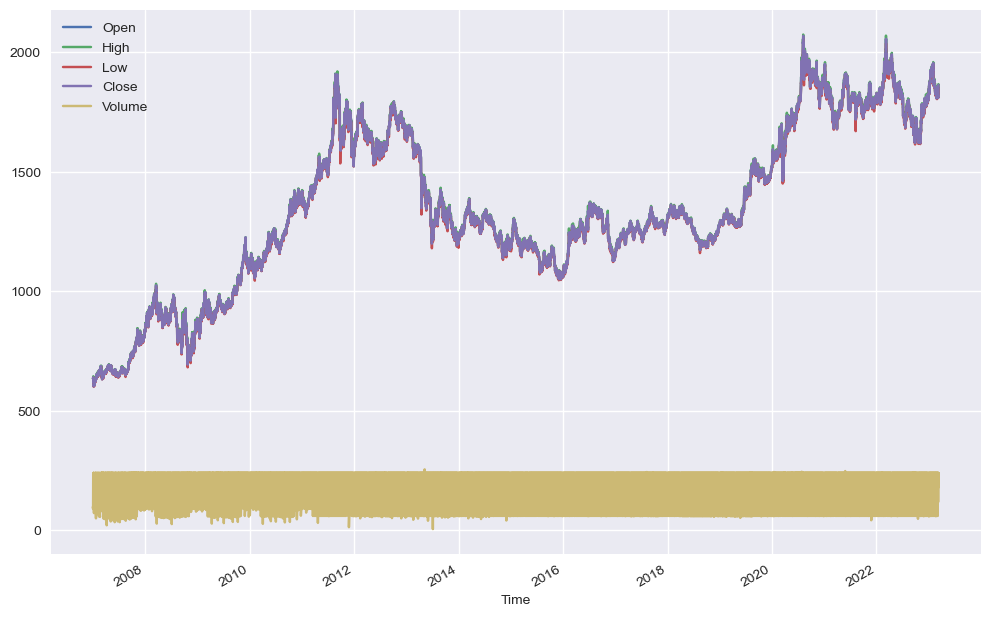

In [8]:
XAUUSD['H4'].plot(figsize = (12, 8))
plt.show()

## ML

### Class and Strategy ML

In [9]:
class Mutiple_Regression(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred[-1] == 1:
            if not self.position:
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)

        elif self.data.pred[-1] == -1:
            if not self.position:
                self.sell(size=1)
            elif self.position.is_long:
                self.position.close()
                self.sell(size=1)

In [10]:
strategy = Mutiple_Regression
account_size = 2000

In [11]:
from backtesting import Backtest
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from util.Save_result_return import save_to_csv
import sys
sys.path.append('../../')


plt.style.use("seaborn-v0_8")


class ML_Regression():

    def __init__(self, data, strategy, start_train, start_test, end_train, end_test, TF):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.start_test = start_test
        self.end_train = end_train
        self.end_test = end_test
        self.TF = TF
        self.data_train = None
        self.data_test = None
        self.results = None
        self.model = None

    def Prepare(self, lags=5):
        data = self.data.loc[self.start_train:self.end_train].copy()
        data["returns"] = np.log(data['Close'].div(data['Close'].shift(1)))
        data["returns_signal"] = data["returns"].shift(-1)
        data.dropna(inplace=True)
        cols = []

        for lag in range(lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        data.dropna(inplace=True)

        lm = LinearRegression(fit_intercept=True)
        lm.fit(data[cols], data['returns_signal'])
        data["pred"] = lm.predict(data[cols])
        data['pred'] = np.sign(data['pred'])

        self.model = lm
        self.data_train = data

    def Predict(self, lags=5):
        data = self.data.loc[self.start_test:self.end_test].copy()
        data["returns"] = np.log(data['Close'].div(data['Close'].shift(1)))
        cols = []

        for lag in range(lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        data.dropna(inplace=True)

        data["pred"] = self.model.predict(data[cols])
        data['pred'] = np.sign(data['pred'])

        self.data_test = data

    def Backtest(self, data, account_size=1000):
        # Assuming you have a Backtest class that performs backtesting
        backtest = Backtest(data, self.strategy,
                            cash=account_size, margin=1 / 100)
        result = backtest.run()
        return result


    def Run(self):
        self.Prepare()
        result_train = self.Backtest(self.data_train)

        self.Predict()
        result_test = self.Backtest(self.data_test)
       
        return result_train, result_test

## TF D1

In [12]:
data = XAUUSD['D1']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'D1'

In [13]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [14]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_6704\2957458901.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


C:\Users\Win10\AppData\Local\Temp\ipykernel_6704\2957458901.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [15]:
train

Start                     2007-01-08 00:00:00
End                       2019-12-30 00:00:00
Duration                   4739 days 00:00:00
Exposure Time [%]                   99.950556
Equity Final [$]                     2155.301
Equity Peak [$]                      2620.041
Return [%]                           115.5301
Buy & Hold Return [%]              148.689509
Return (Ann.) [%]                    4.900427
Volatility (Ann.) [%]               10.274052
Sharpe Ratio                         0.476971
Sortino Ratio                        0.730607
Calmar Ratio                         0.196369
Max. Drawdown [%]                  -24.955171
Avg. Drawdown [%]                   -2.375347
Max. Drawdown Duration     1992 days 00:00:00
Avg. Drawdown Duration       52 days 00:00:00
# Trades                                 1572
Win Rate [%]                        51.526718
Best Trade [%]                      10.617556
Worst Trade [%]                    -11.735448
Avg. Trade [%]                    

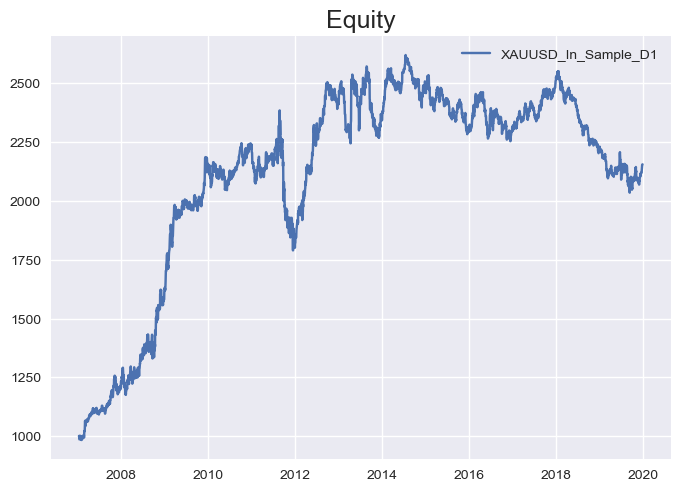

In [16]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [17]:
test

Start                     2020-01-08 00:00:00
End                       2023-03-10 00:00:00
Duration                   1157 days 00:00:00
Exposure Time [%]                   90.659898
Equity Final [$]                       16.748
Equity Peak [$]                      1077.838
Return [%]                           -98.3252
Buy & Hold Return [%]               19.648007
Return (Ann.) [%]                   -64.87446
Volatility (Ann.) [%]               74.456008
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -98.686352
Avg. Drawdown [%]                   -34.25101
Max. Drawdown Duration     1114 days 00:00:00
Avg. Drawdown Duration      382 days 00:00:00
# Trades                                  368
Win Rate [%]                        45.652174
Best Trade [%]                        4.76191
Worst Trade [%]                     -5.389095
Avg. Trade [%]                    

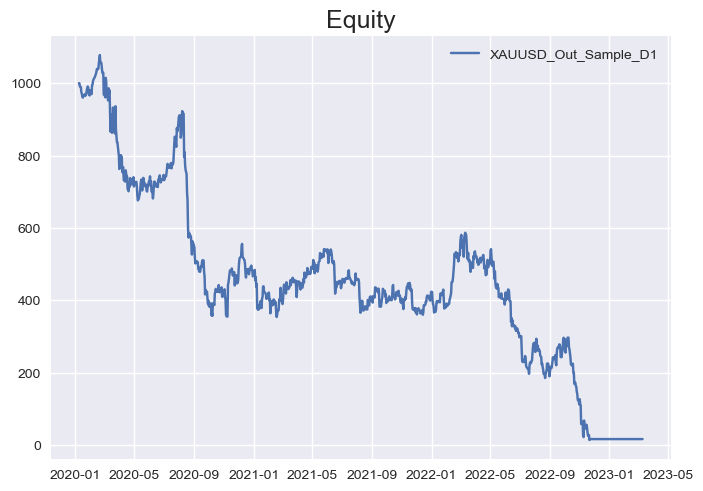

In [18]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [19]:
filename_train = f'result_{TF}_In_Sample.csv'

In [20]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [21]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [22]:
save_to_csv(
    test, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')

## TF H4

In [23]:
data = XAUUSD['H4']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'H4'

In [24]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [25]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_6704\2957458901.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_6704\2957458901.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [26]:
train

Start                     2007-01-02 00:00:00
End                       2019-12-31 16:00:00
Duration                   4746 days 16:00:00
Exposure Time [%]                   99.990414
Equity Final [$]                     4504.369
Equity Peak [$]                       4820.84
Return [%]                           350.4369
Buy & Hold Return [%]              138.448093
Return (Ann.) [%]                    9.811609
Volatility (Ann.) [%]                7.770633
Sharpe Ratio                         1.262652
Sortino Ratio                        2.247481
Calmar Ratio                         0.824452
Max. Drawdown [%]                  -11.900757
Avg. Drawdown [%]                   -0.631622
Max. Drawdown Duration      472 days 00:00:00
Avg. Drawdown Duration        8 days 12:00:00
# Trades                                 9769
Win Rate [%]                        52.226431
Best Trade [%]                      10.643533
Worst Trade [%]                     -6.253184
Avg. Trade [%]                    

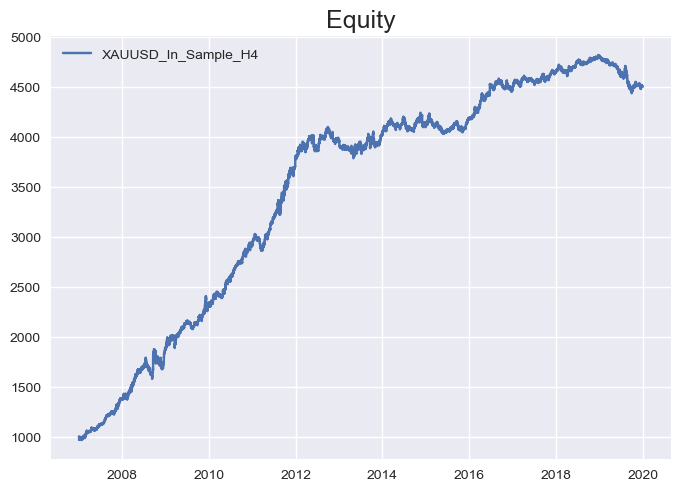

In [27]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [28]:
test

Start                     2020-01-02 20:00:00
End                       2023-03-10 16:00:00
Duration                   1162 days 20:00:00
Exposure Time [%]                   99.960777
Equity Final [$]                      802.465
Equity Peak [$]                      1343.938
Return [%]                           -19.7535
Buy & Hold Return [%]               21.937846
Return (Ann.) [%]                     -5.4477
Volatility (Ann.) [%]               22.773362
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -43.082717
Avg. Drawdown [%]                   -4.994489
Max. Drawdown Duration      774 days 16:00:00
Avg. Drawdown Duration       50 days 05:00:00
# Trades                                 2366
Win Rate [%]                         51.01437
Best Trade [%]                        3.53124
Worst Trade [%]                      -5.36415
Avg. Trade [%]                    

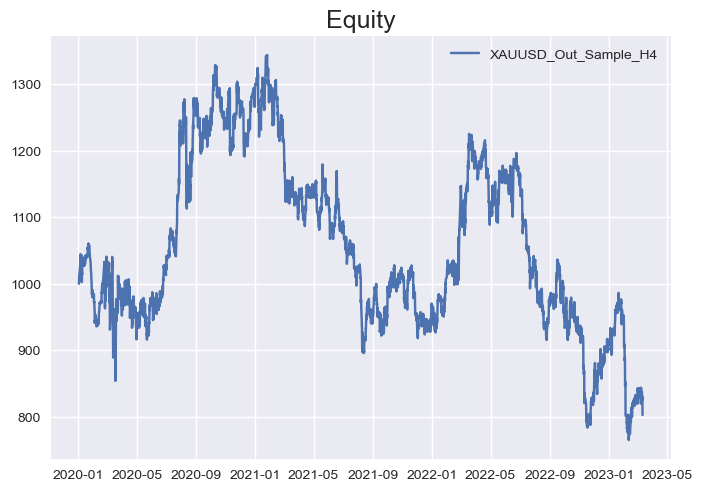

In [29]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [30]:
filename_train = f'result_{TF}_In_Sample.csv'

In [31]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [32]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [33]:
save_to_csv(
    test, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')

## TF H1

In [34]:
data = XAUUSD['H1']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'H1'

In [35]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [36]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_6704\2957458901.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_6704\2957458901.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [37]:
train

Start                     2007-01-01 06:00:00
End                       2019-12-31 20:00:00
Duration                   4747 days 14:00:00
Exposure Time [%]                   99.997471
Equity Final [$]                     2161.276
Equity Peak [$]                      2467.388
Return [%]                           116.1276
Buy & Hold Return [%]              138.749634
Return (Ann.) [%]                    4.908755
Volatility (Ann.) [%]               11.668393
Sharpe Ratio                         0.420688
Sortino Ratio                        0.673818
Calmar Ratio                          0.21046
Max. Drawdown [%]                  -23.323985
Avg. Drawdown [%]                   -0.878578
Max. Drawdown Duration     2644 days 13:00:00
Avg. Drawdown Duration       11 days 18:00:00
# Trades                                17865
Win Rate [%]                        56.356003
Best Trade [%]                       6.254102
Worst Trade [%]                      -8.53064
Avg. Trade [%]                    

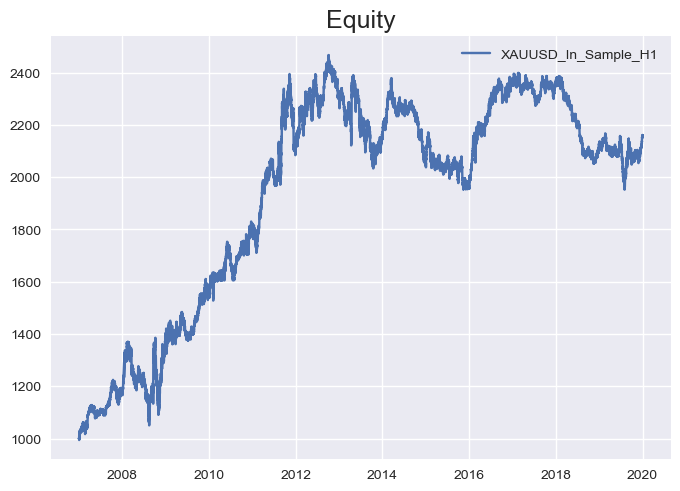

In [38]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [39]:
test

Start                     2020-01-02 05:00:00
End                       2023-03-10 17:00:00
Duration                   1163 days 12:00:00
Exposure Time [%]                   99.989394
Equity Final [$]                     1572.026
Equity Peak [$]                      1730.344
Return [%]                            57.2026
Buy & Hold Return [%]               22.623102
Return (Ann.) [%]                   11.863072
Volatility (Ann.) [%]               19.964648
Sharpe Ratio                         0.594204
Sortino Ratio                        0.949736
Calmar Ratio                         0.472162
Max. Drawdown [%]                  -25.125004
Avg. Drawdown [%]                   -1.110936
Max. Drawdown Duration      646 days 03:00:00
Avg. Drawdown Duration        7 days 02:00:00
# Trades                                 4458
Win Rate [%]                        57.626738
Best Trade [%]                       2.398944
Worst Trade [%]                     -4.090184
Avg. Trade [%]                    

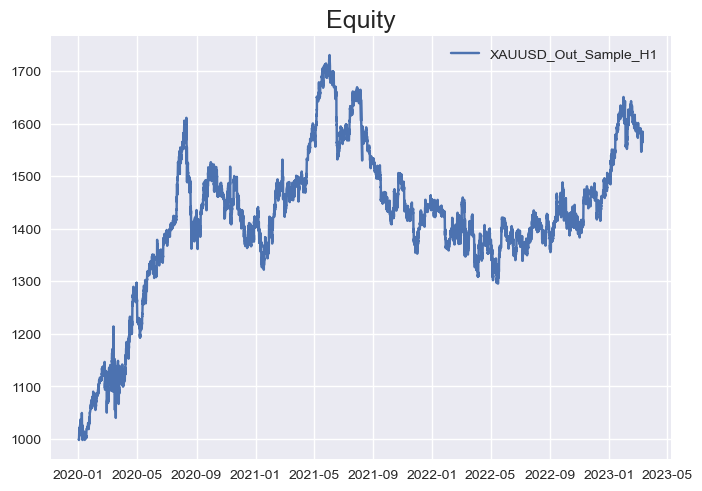

In [40]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [41]:
filename_train = f'result_{TF}_In_Sample.csv'

In [42]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [43]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [44]:
save_to_csv(
    test, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')

## TF M30

In [45]:
data = XAUUSD['M30']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'M30'

In [46]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [47]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_6704\2957458901.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_6704\2957458901.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [48]:
train

Start                     2007-01-01 03:00:00
End                       2019-12-31 21:00:00
Duration                   4747 days 18:00:00
Exposure Time [%]                    99.99873
Equity Final [$]                     2066.646
Equity Peak [$]                      2628.749
Return [%]                           106.6646
Buy & Hold Return [%]              138.820778
Return (Ann.) [%]                    4.606716
Volatility (Ann.) [%]               10.018122
Sharpe Ratio                         0.459838
Sortino Ratio                        0.695739
Calmar Ratio                         0.176958
Max. Drawdown [%]                  -26.032839
Avg. Drawdown [%]                   -0.470249
Max. Drawdown Duration     3070 days 20:30:00
Avg. Drawdown Duration        6 days 20:49:00
# Trades                                62460
Win Rate [%]                        55.886968
Best Trade [%]                       3.114064
Worst Trade [%]                     -9.578469
Avg. Trade [%]                    

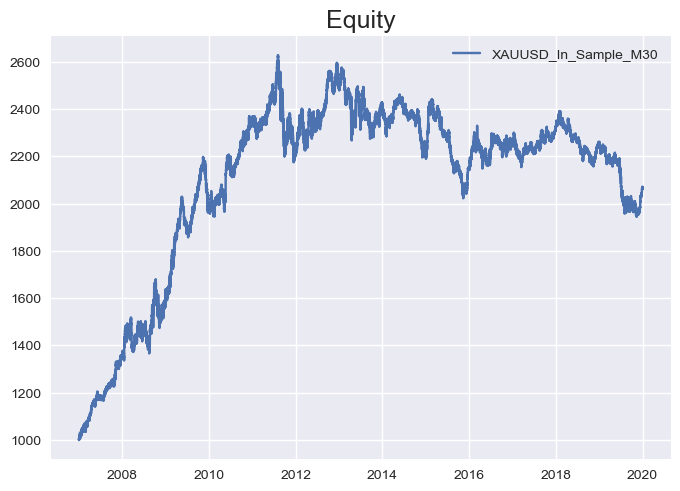

In [49]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [50]:
test

Start                     2020-01-02 02:00:00
End                       2023-03-10 17:30:00
Duration                   1163 days 15:30:00
Exposure Time [%]                   99.994696
Equity Final [$]                     2219.413
Equity Peak [$]                      2269.047
Return [%]                           121.9413
Buy & Hold Return [%]                22.67717
Return (Ann.) [%]                   22.583339
Volatility (Ann.) [%]               21.818027
Sharpe Ratio                         1.035077
Sortino Ratio                        1.858249
Calmar Ratio                         0.976621
Max. Drawdown [%]                  -23.123947
Avg. Drawdown [%]                   -0.701333
Max. Drawdown Duration      253 days 03:30:00
Avg. Drawdown Duration        3 days 04:27:00
# Trades                                15449
Win Rate [%]                        56.249595
Best Trade [%]                       2.056397
Worst Trade [%]                      -4.60021
Avg. Trade [%]                    

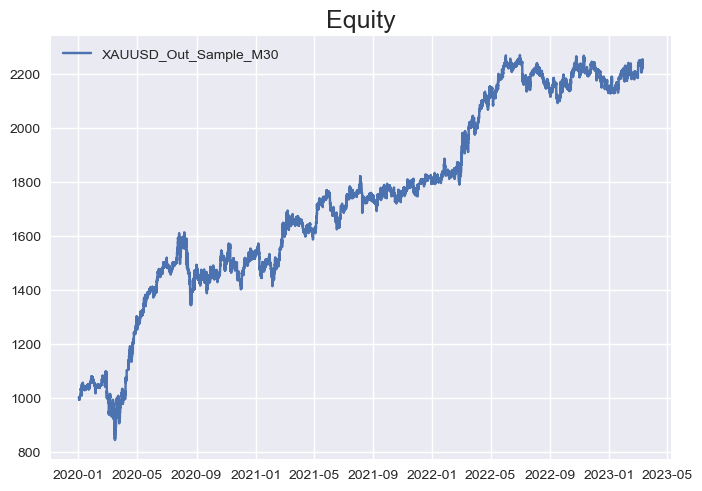

In [51]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [52]:
filename_train = f'result_{TF}_In_Sample.csv'

In [53]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [54]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [55]:
save_to_csv(
    test, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')

## TF M15

In [56]:
data = XAUUSD['M15']
start_train = '2014'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'M15'

In [57]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [58]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_6704\2957458901.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_6704\2957458901.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [59]:
train

Start                     2014-09-23 14:30:00
End                       2019-12-31 21:30:00
Duration                   1925 days 07:00:00
Exposure Time [%]                   99.998394
Equity Final [$]                     1810.406
Equity Peak [$]                      1970.262
Return [%]                            81.0406
Buy & Hold Return [%]               24.218093
Return (Ann.) [%]                    9.515708
Volatility (Ann.) [%]               11.814411
Sharpe Ratio                         0.805432
Sortino Ratio                        1.305666
Calmar Ratio                         0.657954
Max. Drawdown [%]                  -14.462572
Avg. Drawdown [%]                   -0.368969
Max. Drawdown Duration      322 days 08:15:00
Avg. Drawdown Duration        2 days 18:39:00
# Trades                                52129
Win Rate [%]                        58.115444
Best Trade [%]                       1.898497
Worst Trade [%]                     -2.498064
Avg. Trade [%]                    

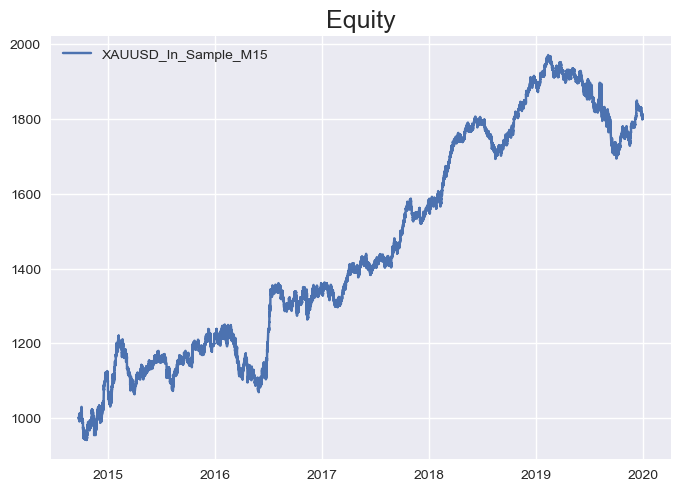

In [60]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [61]:
test

Start                     2020-01-02 00:30:00
End                       2023-03-10 17:45:00
Duration                   1163 days 17:15:00
Exposure Time [%]                   99.997348
Equity Final [$]                     2515.321
Equity Peak [$]                      2580.052
Return [%]                           151.5321
Buy & Hold Return [%]               22.768468
Return (Ann.) [%]                   26.658779
Volatility (Ann.) [%]               21.314785
Sharpe Ratio                         1.250718
Sortino Ratio                        2.418559
Calmar Ratio                         1.361448
Max. Drawdown [%]                  -19.581198
Avg. Drawdown [%]                   -0.475712
Max. Drawdown Duration      365 days 20:00:00
Avg. Drawdown Duration        1 days 22:55:00
# Trades                                32156
Win Rate [%]                        58.496082
Best Trade [%]                       2.035179
Worst Trade [%]                     -3.427653
Avg. Trade [%]                    

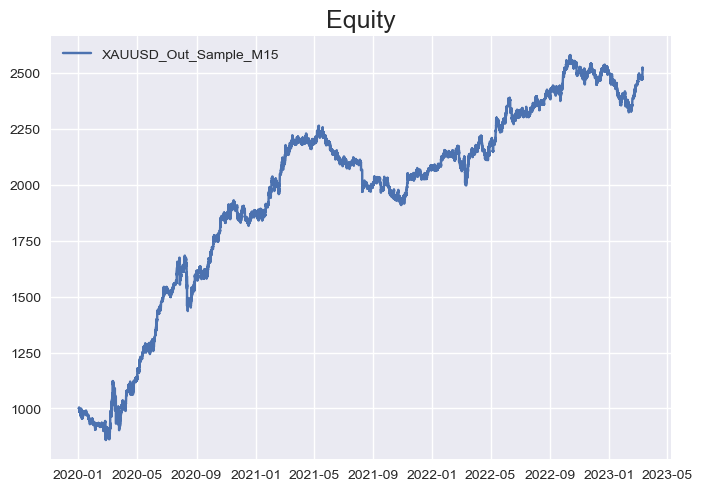

In [62]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [63]:
filename_train = f'result_{TF}_In_Sample.csv'

In [64]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [65]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [66]:
save_to_csv(
    test, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')

## TF M5

In [67]:
data = XAUUSD['M5']
start_train = '2020'
start_test = '2023'
end_train = '2022'
end_test = '2023'
TF = 'M5'

In [68]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [69]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_6704\2957458901.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_6704\2957458901.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [70]:
train

Start                     2020-05-15 11:40:00
End                       2022-12-30 21:50:00
Duration                    959 days 10:10:00
Exposure Time [%]                   99.998928
Equity Final [$]                     5079.776
Equity Peak [$]                      5176.066
Return [%]                           407.9776
Buy & Hold Return [%]                5.290959
Return (Ann.) [%]                   64.441779
Volatility (Ann.) [%]                17.21515
Sharpe Ratio                         3.743318
Sortino Ratio                       12.488506
Calmar Ratio                         6.627687
Max. Drawdown [%]                   -9.723118
Avg. Drawdown [%]                   -0.148612
Max. Drawdown Duration       30 days 02:40:00
Avg. Drawdown Duration        0 days 07:53:00
# Trades                               105410
Win Rate [%]                        61.345223
Best Trade [%]                          1.128
Worst Trade [%]                     -2.698002
Avg. Trade [%]                    

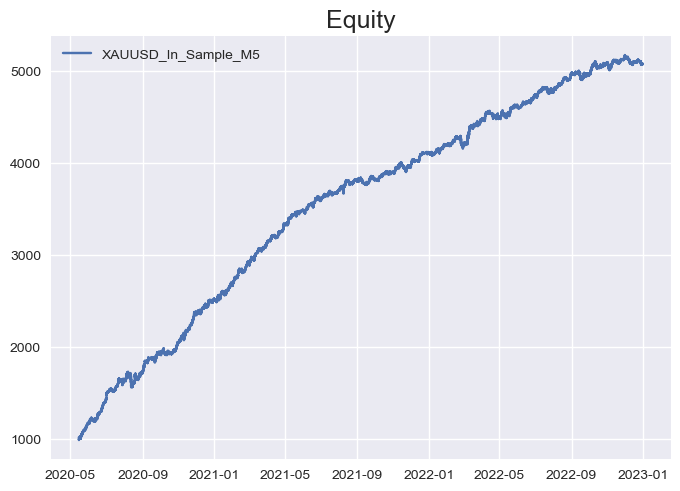

In [71]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [72]:
test

Start                     2023-01-02 23:30:00
End                       2023-03-10 17:55:00
Duration                     66 days 18:25:00
Exposure Time [%]                   99.985063
Equity Final [$]                     1260.951
Equity Peak [$]                      1272.768
Return [%]                            26.0951
Buy & Hold Return [%]                1.999557
Return (Ann.) [%]                  170.477572
Volatility (Ann.) [%]               56.019979
Sharpe Ratio                         3.043157
Sortino Ratio                       13.925772
Calmar Ratio                        22.431772
Max. Drawdown [%]                   -7.599826
Avg. Drawdown [%]                   -0.330442
Max. Drawdown Duration       13 days 20:30:00
Avg. Drawdown Duration        0 days 06:43:00
# Trades                                 7579
Win Rate [%]                        61.538462
Best Trade [%]                       0.473524
Worst Trade [%]                     -1.354524
Avg. Trade [%]                    

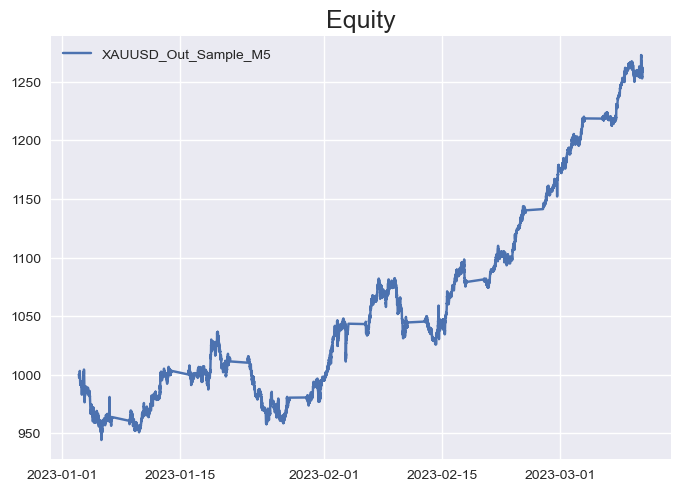

In [73]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [74]:
filename_train = f'result_{TF}_In_Sample.csv'

In [75]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [76]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [77]:
save_to_csv(
    test, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')

## TF M1

In [78]:
data = XAUUSD['M1']
start_train = '2022'
start_test = '2023'
end_train = '2022'
end_test = '2023'
TF = 'M1'

In [79]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [80]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_6704\2957458901.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_6704\2957458901.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [81]:
train

Start                     2022-08-16 23:19:00
End                       2022-12-30 21:57:00
Duration                    135 days 22:38:00
Exposure Time [%]                   99.998497
Equity Final [$]                     1359.122
Equity Peak [$]                      1436.776
Return [%]                            35.9122
Buy & Hold Return [%]                  2.6722
Return (Ann.) [%]                   93.604432
Volatility (Ann.) [%]               38.874263
Sharpe Ratio                         2.407877
Sortino Ratio                        8.803637
Calmar Ratio                        10.052066
Max. Drawdown [%]                    -9.31196
Avg. Drawdown [%]                   -0.215205
Max. Drawdown Duration       38 days 07:36:00
Avg. Drawdown Duration        0 days 05:26:00
# Trades                                50165
Win Rate [%]                        57.767368
Best Trade [%]                       0.894083
Worst Trade [%]                     -0.953713
Avg. Trade [%]                    

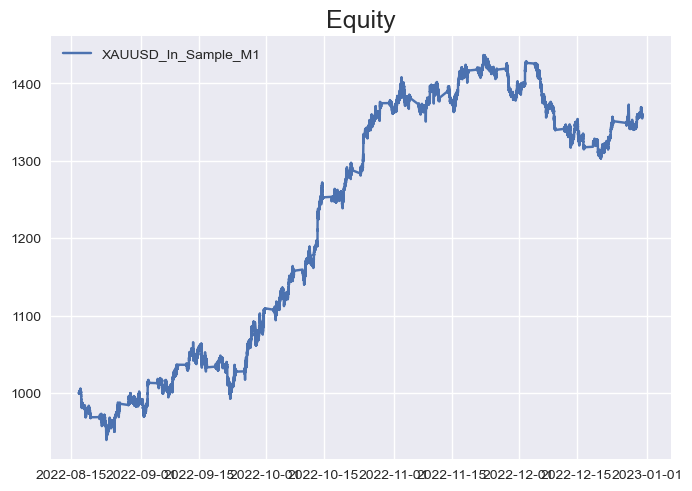

In [82]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [83]:
test

Start                     2023-01-02 23:08:00
End                       2023-03-10 17:59:00
Duration                     66 days 18:51:00
Exposure Time [%]                   99.997013
Equity Final [$]                     1270.355
Equity Peak [$]                      1276.168
Return [%]                            27.0355
Buy & Hold Return [%]                1.903539
Return (Ann.) [%]                  185.502809
Volatility (Ann.) [%]               67.490769
Sharpe Ratio                         2.748566
Sortino Ratio                       15.847665
Calmar Ratio                        14.020854
Max. Drawdown [%]                  -13.230493
Avg. Drawdown [%]                   -0.154275
Max. Drawdown Duration       42 days 21:39:00
Avg. Drawdown Duration        0 days 03:19:00
# Trades                                25327
Win Rate [%]                        58.265882
Best Trade [%]                       0.891826
Worst Trade [%]                     -0.792019
Avg. Trade [%]                    

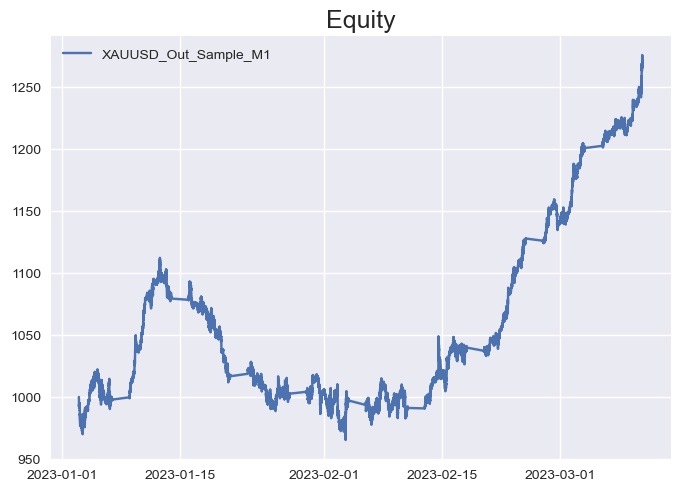

In [84]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [85]:
filename_train = f'result_{TF}_In_Sample.csv'

In [86]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')